# Dynamic Hedging of an European Call Option

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime
from datetime import date
from collections import deque


from scipy.stats import norm

In [2]:
ticker = yf.Ticker("MSFT")
maturity = ticker.options



('2024-10-11',
 '2024-10-18',
 '2024-10-25',
 '2024-11-01',
 '2024-11-08',
 '2024-11-15',
 '2024-11-22',
 '2024-12-20',
 '2025-01-17',
 '2025-02-21',
 '2025-03-21',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15')

In [3]:
#Enter which ticker to analyze 
ticker = "MSFT"
stock = yf.Ticker(ticker)
today = date.today()

#Getting the initial price
stock_data = stock.history(start="2010-01-01",end="2024-01-01")
prices = stock_data[["Close"]]
prices.columns = [ticker]
log_returns = np.log(prices).diff().dropna().to_numpy().flatten()
#Initial stock price
s0 = prices[ticker].to_numpy().flatten()[-1]
print("S0:", s0)








S0: 373.9959716796875


In [4]:
# #Calculating the volatility


def EWMA(window_size, log_ret):
    lamb = 0.94
    weights = np.array([(1 - lamb) * lamb**i for i in range(window_size)])
    weighted_squared_returns = weights * np.square(np.array(log_ret))
    variance = weighted_squared_returns.sum()
    return np.sqrt(variance * 252)  # Annualized volatility

Using EWMA to account for volatility clustering and to make the model more realistic

In [9]:
#Function for dynamically hedging an option with a daily frequency
#To decrease the frequency, the volatility calculation needs to be updated!


def dynamic_hedge(s0, maturity, window_size, n, freq=252): 
    '''
    s0: initial stock price, see code above
    maturty: time to maturity, in years
    window_size: how many days behind to look for the volatility estimation
    n: amount of iterations
    freq: frequency of hedge updates, set to 252, otherwise need to change EWMA code
    '''
    r = 0.03 #Current risk-free rate on the bank-account, can be exapnded to a modell in future
    present_vals = np.empty(n)
    delta_t = maturity/freq
    K = round(1.2*s0,0) #Strike price that is 120% of the current price
    prev_returns = log_returns[-window_size:]
    vol = EWMA(window_size, prev_returns)
    Z = np.random.standard_normal((n,freq+1))
    for i in range(n):
        cash_flow = np.zeros(freq) #Vector with the cash flow from the hedging
        s = s0 #Initial stock price
        vol = EWMA(window_size,log_returns[-window_size:])

        for t in range(freq+1):
            
            #Time left to maturity
            if t == freq:
                V = np.maximum(s-K, 0)
            else:
                #Black-Scholes option price
                T = delta_t * (freq-t) #Time left to maturity
                d1 = (np.log(s/K)+(r+(vol**2)/2)*T)/(vol*np.sqrt(T))
                d2 = d1 - vol*np.sqrt(T)
                V = (s*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)) #V = option value
            
            #Hedging and calculating the cash flow from the previous periods hedge
            if t == 0:
                delta = norm.cdf(d1)
                y = (V-delta*s)
            else:
                P = delta*s + np.exp(r*delta_t)*y # P = portfolio value
                cash_flow[t-1] = np.exp(-r*delta_t*t)*(P-V) #Discounted value of the difference between protfolio and option value
                delta = norm.cdf(d1)
                y = V - delta*s

            #Next periods stock price
            prev_s = s
            s = s*np.exp((r - (vol**2)/2)*delta_t + vol*np.sqrt(delta_t)*Z[i,t])
            new_s = s
            #Calculating the new window where the previous periods return is added to the volatility
            prev_returns = np.append(prev_returns[1:], np.log(new_s/prev_s))
            vol = EWMA(window_size, prev_returns)
            
        #Result from the delta hedging
        present_vals[i] = np.sum(cash_flow)
    mean = np.mean(present_vals)
    std = np.std(present_vals)
    return mean, std, present_vals

In [10]:

mean, std, distribution = dynamic_hedge(s0, 1, 60, 1000)

The mean difference of the portfolio is: 11.028, the standard deviation is: 3.724


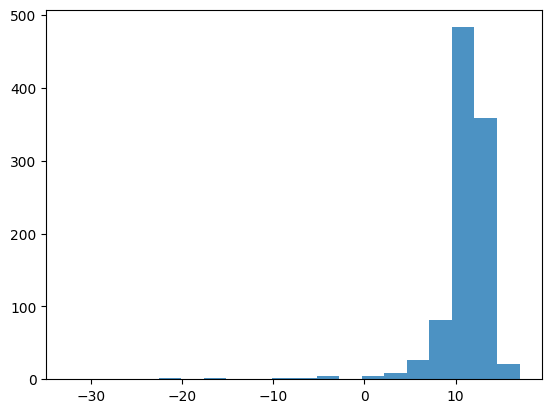

In [12]:
print(f"The mean difference of the portfolio is: {round(mean,3)}, the standard deviation is: {round(std,3)}")
plt.hist(distribution, bins = 20, alpha=0.8)
plt.show()

As can be seen from the figure, the dynamic hedge results in a average profit of about $11. This means that by hedging the portfolio, the investor can earn on average $11 for free. However, when taking into account transaction costs, these profits might be smaller.